[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pytextbook/pytextbook/blob/main/7.2.%20seoul-120-baseline-rnn.ipynb) 

## RNN (Recurrent Neural Network) 으로 텍스트 분류하기

* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN

## 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 미리보기 및 요약

In [2]:
df = pd.read_csv("https://bit.ly/seoul-120-text-csv")
df.shape

(2645, 5)

In [3]:
# 제목과 내용을 합쳐서 문서라는 파생변수 생성
df["문서"] = df["제목"] + df["내용"]
df.head()

,번호,분류,제목,내용,내용번호,문서
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464,아빠 육아휴직 장려금아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려...
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045,[서울산업진흥원] 서울메이드란?서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하...
2,2643,환경,(강북구) 정비중,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...,23032485,(강북구) 정비중강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높...
3,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)광진맘택시 운영임산부영아 양육가정 ..."
4,2641,복지,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798,마포 뇌병변장애인 비전센터마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 ...


In [4]:
# value_counts()로 분류별 빈도수 확인
df["분류"].value_counts()

행정        1098
경제         823
복지         217
환경         124
주택도시계획     110
문화관광        96
교통          90
안전          51
건강          23
여성가족        13
Name: 분류, dtype: int64

In [5]:
# 분류별 빈도수 값으로 불균형이 심해 전체 데이터로 예측을 하면 성능이 떨어질 수 있음
# 일부 상위 분류 데이터만을 추출해 사용
df = df[df["분류"].isin(["행정", "경제", "복지"])]
# df = df[df["분류"].isin(["행정", "경제"])]

In [6]:
# 정답(label) 값
label_name = "분류"

In [7]:
# 독립변수(X, 문제)와 종속변수(y, 정답)
X = df["문서"]
y = df[label_name]

## label one-hot 형태로 만들기

In [8]:
# get_dummies 를 사용하여 label 값을 one-hot 형태로 생성
y_onehot = pd.get_dummies(y)

In [9]:
# train_test_split 으로 학습과 예측에 사용할 데이터를 나누기
# 정답값은 y_onehot 으로 지정
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1710,), (428,), (1710, 3), (428, 3))

In [10]:
y_train

,경제,복지,행정
2052,0,0,1
2594,1,0,0
1061,0,0,1
78,0,0,1
70,0,0,1
...,...,...,...
1571,1,0,0
1533,1,0,0
671,1,0,0
550,1,0,0


## 벡터화
### 토큰화

1. 이 클래스를 사용하면 각 텍스트를 일련의 정수(각 정수는 사전에 있는 토큰의 인덱스임) 또는 단어 수에 따라 각 토큰의 계수가 이진일 수 있는 벡터로 변환하여 텍스트 말뭉치를 벡터화할 수 있습니다.(tf-idf 기반)

2. 매개변수
- num_words
: 단어 빈도에 따라 유지할 최대 단어 수입니다. 가장 일반적인 단어 만 유지됩니다. 
-filters
: 각 요소가 텍스트에서 필터링될 문자인 문자열입니다. 기본값은 문자를 제외한 모든 구두점과 탭 및 줄 바꿈 '입니다.
- lower
: 부울. 텍스트를 소문자로 변환할지 여부입니다.
- split
: str. 단어 분할을 위한 구분 기호입니다.
- char_level
: True이면 모든 문자가 토큰으로 처리됩니다.
- oov_token
: 주어진 경우, 그것은 word_index에 추가되고 text_to_sequence 호출 중에 어휘 밖의 단어를 대체하는 데 사용됩니다.

3. 벡터화 과정
- Tokenizer 인스턴스를 생성
- fit_on_texts와 word_index를 사용하여 key value로 이루어진 딕셔너리를 생성
- texts_to_sequences를 이용하여 text 문장을 숫자로 이루어진 리스트로 변경
- 마지막으로 pad_sequences를 이용하여 리스트의 길이를 통일화


* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

### 시퀀스 만들기

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
# Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
# num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환
# 단어 사전의 크기를 지정해 주기 위해 vocab_size를 지정
# vocab_size는 텍스트 데이터의 전체 단어 집합의 크기

vocab_size = 1000
oov_tok = "<oov>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_tok)
tokenizer

In [13]:
# Tokenizer 에 데이터 실제로 입력합니다.
# fit_on_texts와 word_index를 사용하여 key value로 이루어진 딕셔너리를 생성
tokenizer.fit_on_texts(X_train)

In [14]:
# tokenizer의 word_index 속성은 단어와 숫자의 키-값 쌍을 포함하는 딕셔너리를 반환
# 이때, 반환 시 자동으로 소문자로 변환되어 들어가며, 느낌표나 마침표 같은 구두점은 자동으로 제거
# 각 인덱스에 해당하는 단어가 무엇인지 확인

word_to_index = tokenizer.word_index
sorted(word_to_index)[:10]

["'",
 "'25시",
 "'경복궁",
 "'관리주체는",
 "'기타운동시설운용업'의",
 "'노원'",
 "'당해",
 "'불허용도'란",
 "'새랑'의",
 "'성공창업"]

In [15]:
# 단어별 빈도수를 확인
list(tokenizer.word_counts.items())[:5]

[('우리아이의', 2), ('배정', 11), ('초등학교를', 2), ('알고', 45), ('싶어요', 7)]

In [16]:
# 단어별 빈도수를 확인
word_df = pd.DataFrame(tokenizer.word_counts.items(), columns = ['단어', '빈도수'])
word_df.sort_values(by="빈도수", ascending=False).T

,243,1341,73,460,204,245,69,137,194,533,...,16513,16512,16511,16510,16508,16507,16503,16502,16501,36508
단어,및,돋움,수,경우,또는,등,있는,년,월,있습니다,...,궁내동,분당구,한국기기유화시험연구원,놀이시설팀,가산디지털로,제정되어,검사입니다,안전검사기관으로,시설및,설치하는가
빈도수,1455,1110,771,593,550,547,411,398,379,378,...,1,1,1,1,1,1,1,1,1,1


In [17]:
# texts_to_sequences를 이용하여 text 문장을 숫자로 이루어진 리스트로 변경
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

## 패딩(Padding)

* API Document: https://www.tensorflow.org/tutorials/keras/text_classification

In [18]:
# 독립변수를 전처리합니다. 
# 문장의 길이가 제각각인 벡터의 크기를 패딩 작업을 통해 나머지 빈 공간을 0으로 채움
# max_length는 패딩의 기준이 됨
# padding_type='post' 는 패딩을 앞(기본값)이 아닌 뒤('post')에 채움
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 500
padding_type = "post"
# padding_type = "pre"

X_train_sp = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
X_test_sp = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)


print(X_train.shape)

(1710,)


## 모델 만들기

### simple RNN

* API Document: https://www.tensorflow.org/guide/keras/rnn
* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNNCell

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dropout, BatchNormalization

In [20]:
# 하이퍼파라미터(모델링할 때 사용자가 직접 세팅해주는 값)을 설정
# vocab_size는 텍스트 데이터의 전체 단어 집합의 크기
# embedding_dim는 임베딩 할 벡터의 차원
# max_length는 패딩의 기준

embedding_dim = 64

In [21]:
# 클래스의 수는 분류될 예측값의 종류
# 정답값이 one-hot 형태로 인코딩 되어 있기 때문에 정답값의 컬럼의 수가 예측값의 종류가 됨
n_class = y_train.shape[1]
n_class

3

## Bidirectional RNN

In [22]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
#     BatchNormalization(),
    Bidirectional(LSTM(32)),
#     Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(n_class, activation='softmax')
])

* https://www.tensorflow.org/guide/keras/rnn#%EC%96%91%EB%B0%A9%ED%96%A5_rnn

### Bidirectional LSTM

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1600px-Long_Short-Term_Memory.svg.png" width="400">

* 출처 : https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D

* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

### GRU

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Gated_Recurrent_Unit%2C_base_type.svg/440px-Gated_Recurrent_Unit%2C_base_type.svg.png" width="400">

* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

## 모델 컴파일

In [23]:
# 여러개 정답 중 하나 맞추는 문제이며, 정답값이 one-hot 형태이기 때문에
# 손실 함수는 categorical_crossentropy를 사용
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics = ['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           64000     
                                                                 
 bidirectional (Bidirectiona  (None, 500, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 172,355
Trainable params: 172,355
Non-trai

## 학습

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [25]:
# 모델 학습을 실행
history = model.fit(X_train_sp, y_train, 
                    epochs=100, batch_size=64, callbacks=early_stop, validation_split=0.2,
                    use_multiprocessing=True)  

Epoch 1/100
22/22 [==============================] - 45s 2s/step - loss: 0.9872 - accuracy: 0.5175 - val_loss: 0.9461 - val_accuracy: 0.4942
Epoch 2/100
22/22 [==============================] - 33s 2s/step - loss: 0.9263 - accuracy: 0.5190 - val_loss: 0.9146 - val_accuracy: 0.4942
Epoch 3/100
22/22 [==============================] - 33s 2s/step - loss: 0.8987 - accuracy: 0.5468 - val_loss: 0.9008 - val_accuracy: 0.5292
Epoch 4/100
22/22 [==============================] - 32s 1s/step - loss: 0.8501 - accuracy: 0.6016 - val_loss: 0.8479 - val_accuracy: 0.6023
Epoch 5/100
22/22 [==============================] - 33s 2s/step - loss: 0.7346 - accuracy: 0.6996 - val_loss: 0.7860 - val_accuracy: 0.6696
Epoch 6/100
22/22 [==============================] - 31s 1s/step - loss: 0.6180 - accuracy: 0.7442 - val_loss: 0.7391 - val_accuracy: 0.6433
Epoch 7/100
22/22 [==============================] - 32s 1s/step - loss: 0.4862 - accuracy: 0.8070 - val_loss: 0.8549 - val_accuracy: 0.7105
Epoch 8/100
2

In [26]:
# 모델 학습의 결과값을 데이터 프레임으로 만들어 확인
df_hist = pd.DataFrame(history.history)

In [27]:
# 모델 학습 결과을 그래프로 시각화
df_hist

,loss,accuracy,val_loss,val_accuracy
0,0.987151,0.517544,0.946125,0.494152
1,0.926311,0.519006,0.914553,0.494152
2,0.898712,0.546784,0.900769,0.529240
3,0.850071,0.601608,0.847878,0.602339
4,0.734621,0.699561,0.785979,0.669591
5,0.617952,0.744152,0.739092,0.643275
6,0.486179,0.807018,0.854934,0.710526
7,0.474456,0.827485,0.789133,0.690058
8,0.359615,0.869152,0.796719,0.684211
9,0.294058,0.896930,0.924730,0.692982


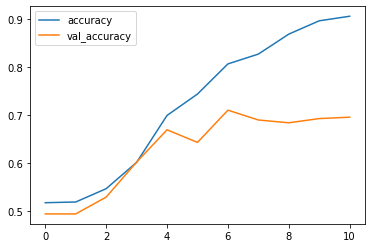

In [28]:
df_hist[["accuracy", "val_accuracy"]].plot()

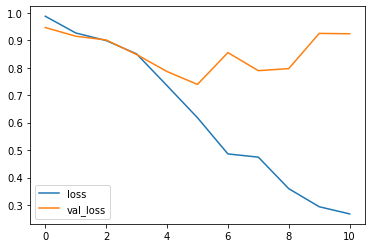

In [29]:
df_hist[["loss", "val_loss"]].plot()

## 예측

In [30]:
# predict() 메서드로 모델 예측
y_pred = model.predict(X_test_sp)
y_pred[:10]

14/14 [==============================] - 5s 223ms/step


array([[0.04029479, 0.01259641, 0.94710886],
       [0.19934632, 0.33347803, 0.46717563],
       [0.27292505, 0.01636682, 0.7107081 ],
       [0.9922458 , 0.0032146 , 0.00453948],
       [0.9856799 , 0.00695921, 0.00736091],
       [0.19694512, 0.04934863, 0.7537062 ],
       [0.17981924, 0.05678767, 0.76339316],
       [0.9838552 , 0.00562436, 0.01052044],
       [0.05183903, 0.01426377, 0.9338971 ],
       [0.04421081, 0.10807092, 0.84771824]], dtype=float32)

## 평가

In [31]:
# numpy.argmax를 이용해 가장 큰 값의 인덱스들을 반환한 값(클래스 예측)을 y_predict에 할당
y_predict = np.argmax(y_pred, axis=1)
y_predict[:10]

array([2, 2, 2, 0, 0, 2, 2, 0, 2, 2])

In [32]:
# numpy.argmax를 이용해 가장 큰 값의 인덱스들을 반환한 값(클래스 예측)을 y_test_val에 할당
y_test_val = np.argmax(y_test.values, axis=1)

In [33]:
# 실제값과 예측값을 비교하여 맞춘 값의 평균을 확인
(y_test_val == y_predict).mean()

0.6822429906542056

In [34]:
# 모델에 설정된 손실 값 및 메트릭 값을 반환하여 평가
test_loss, test_acc = model.evaluate(X_test_sp, y_test)
test_loss, test_acc 

14/14 [==============================] - 4s 308ms/step - loss: 0.9429 - accuracy: 0.6822


(0.9428667426109314, 0.6822429895401001)